# CSI4142 - Fundamentals of Data Science Assignment 2  

## *Data Cleaning*  

**Professor**: Caroline Barrière  
**Students**: Mohamed-Obay Alshaer & Samih Karroum  
**Student Numbers**: 300170489 & 300188957  
**Submission Date**: February 25th, 2025  
**Group Number**: 39  

---  

## Assignment Overview  

This notebook implements an **Imputation Experiment**, designed to evaluate different imputation techniques for handling missing data. The experiment consists of **three imputation tests**, each focusing on a different attribute and missing data mechanism. The process for each test follows these four steps:  

1. **Attribute Selection & Missing Data Simulation** – An attribute is chosen, and missing values are artificially introduced following a specific missing data mechanism:  
   - **MCAR (Missing Completely at Random)**  
   - **MAR (Missing at Random)**  
   - **MNAR (Missing Not at Random)**  

2. **Imputation Method Selection & Implementation** – One of the following imputation techniques is programmed to replace the missing values:  
   - **Default Value Imputation**  
   - **Random Sample Imputation**  
   - **Time-based Imputation**  
   - **Regression Imputation**  
   - **Predictive Imputation**  
   - **Similarity-based Imputation**  
   - **MICE (Multiple Imputation by Chained Equations)**  

3. **Imputation Execution** – The selected method is applied to fill in the missing values.  

4. **Evaluation of Imputation Performance** – The effectiveness of the imputation method is assessed using appropriate evaluation metrics.  

Each test uses a different attribute, a different imputation technique, and a distinct missing data mechanism to provide a comprehensive analysis of imputation methods. The notebook contains all necessary details to understand and reproduce the experiments, including attribute selection, missing data introduction, imputation method implementation, and evaluation results.

---  

## Dataset Description  

The World Happness Report 2019 dataset tracks various metrics across all countries and scores rankinks based on conglomerated statistics. This dataset works well to be dataset 2 as many of these countries share very similar metrics across the board and geographically even can signal that replacing missing data with data that is generated with impudation can prove to be accurate. We will delve into this dataset further by applying three methods for impudation against three different methods to lose data.


In [37]:



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [38]:
# Load the dataset
url = "https://raw.githubusercontent.com/ObayAlshaer/CSI4142_Assignment-2/dataset-2/Dataset2/2019.csv"
happiness_df = pd.read_csv(url)

# Display the first 5 rows of the dataset
happiness_df.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298


In [39]:
# Display basic info about the dataset
print("Dataset shape:", happiness_df.shape)
print("\nFirst 5 rows:")
print(happiness_df.head())

# Make a copy of the original dataset for later comparison
original_df = happiness_df.copy()

# Function to introduce missing values with different mechanisms
def introduce_missing_values(df, column, mechanism='MCAR', missing_rate=0.2):
    df_missing = df.copy()
    n = len(df)
    n_missing = int(n * missing_rate)
    
    # Set random seed for reproducibility
    np.random.seed(42)
    
    if mechanism == 'MCAR':
        # Missing Completely At Random - pure random selection
        missing_indices = np.random.choice(df.index, size=n_missing, replace=False)
    elif mechanism == 'MAR':
        # Missing At Random - depends on Overall rank
        weights = df['Overall rank'] / df['Overall rank'].sum()
        missing_indices = np.random.choice(df.index, size=n_missing, replace=False, p=weights)
    elif mechanism == 'MNAR':
        # Missing Not At Random - depends on the value itself
        values = df[column].copy()
        # Ensure all weights are positive
        values = values - values.min() + 0.1 if values.min() < 0 else values
        weights = values / values.sum()
        missing_indices = np.random.choice(df.index, size=n_missing, replace=False, p=weights)
    
    # Set values to NaN
    df_missing.loc[missing_indices, column] = np.nan
    
    print(f"Created {n_missing} missing values ({missing_rate*100:.0f}%) in column '{column}' using {mechanism} mechanism")
    
    return df_missing, missing_indices

# Function to evaluate imputation performance
def evaluate_imputation(original_values, imputed_values):
    mae = mean_absolute_error(original_values, imputed_values)
    rmse = np.sqrt(mean_squared_error(original_values, imputed_values))
    r2 = r2_score(original_values, imputed_values)
    
    return {'MAE': mae, 'RMSE': rmse, 'R²': r2}

# Visual function to compare original vs imputed values
def plot_comparison(original, imputed, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(original, imputed, alpha=0.7)
    plt.plot([original.min(), original.max()], 
             [original.min(), original.max()], 
             'k--', lw=2)
    plt.xlabel('Original Values')
    plt.ylabel('Imputed Values')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


Dataset shape: (156, 9)

First 5 rows:
   Overall rank Country or region  Score  GDP per capita  Social support  \
0             1           Finland  7.769           1.340           1.587   
1             2           Denmark  7.600           1.383           1.573   
2             3            Norway  7.554           1.488           1.582   
3             4           Iceland  7.494           1.380           1.624   
4             5       Netherlands  7.488           1.396           1.522   

   Healthy life expectancy  Freedom to make life choices  Generosity  \
0                    0.986                         0.596       0.153   
1                    0.996                         0.592       0.252   
2                    1.028                         0.603       0.271   
3                    1.026                         0.591       0.354   
4                    0.999                         0.557       0.322   

   Perceptions of corruption  
0                      0.393  
1        

IMPUTATION METHOD 1: REGRESSION IMPUTATION
Created 31 missing values (20%) in column 'GDP per capita' using MAR mechanism

Regression Imputation Results:
MAE: 0.1470
RMSE: 0.1803
R²: 0.8001

Feature Importance:
                   Feature  Importance
2  Healthy life expectancy    0.859144
1           Social support    0.260557
0                    Score    0.071598


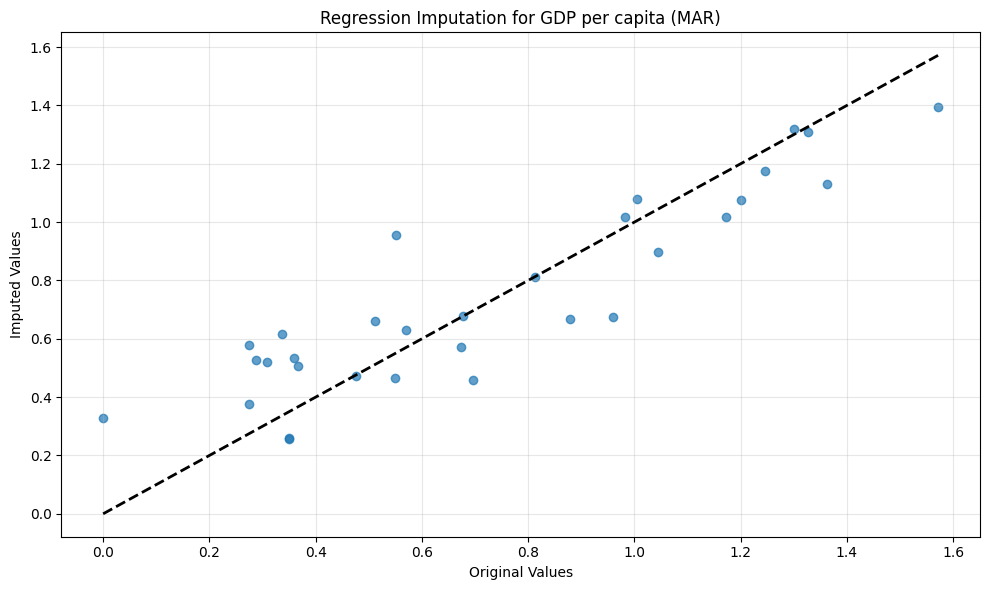

In [40]:
print("IMPUTATION METHOD 1: REGRESSION IMPUTATION")

# Choose column and introduce missing values
target_column = 'GDP per capita'
missing_mechanism = 'MAR'
df_missing_1, missing_indices_1 = introduce_missing_values(
    original_df, target_column, mechanism=missing_mechanism, missing_rate=0.2
)

# Split data into training (non-missing) and imputation (missing) sets
df_train = df_missing_1.dropna(subset=[target_column])
df_impute = df_missing_1[df_missing_1[target_column].isna()]

# Select features for regression model
features = ['Score', 'Social support', 'Healthy life expectancy']
X_train = df_train[features]
y_train = df_train[target_column]

# Train regression model
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

# Predict missing values
X_impute = df_impute[features]
y_pred = regression_model.predict(X_impute)

# Fill missing values with predictions
df_imputed_1 = df_missing_1.copy()
df_imputed_1.loc[df_imputed_1[target_column].isna(), target_column] = y_pred

# Evaluate regression imputation
original_values = original_df.loc[missing_indices_1, target_column]
imputed_values = df_imputed_1.loc[missing_indices_1, target_column]
regression_metrics = evaluate_imputation(original_values, imputed_values)

print("\nRegression Imputation Results:")
for metric, value in regression_metrics.items():
    print(f"{metric}: {value:.4f}")

# Show feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': np.abs(regression_model.coef_)
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Plot comparison
plot_comparison(
    original_values, 
    imputed_values, 
    f'Regression Imputation for {target_column} ({missing_mechanism})'
)

IMPUTATION METHOD 2: KNN IMPUTATION
Created 39 missing values (25%) in column 'Freedom to make life choices' using MCAR mechanism
KNN with k=3: MAE=0.0864, RMSE=0.1042, R²=0.1417
KNN with k=5: MAE=0.0842, RMSE=0.0999, R²=0.2114
KNN with k=7: MAE=0.0910, RMSE=0.1074, R²=0.0876
KNN with k=10: MAE=0.0869, RMSE=0.1050, R²=0.1279
KNN with k=15: MAE=0.0865, RMSE=0.1033, R²=0.1572

Best k value: 5

KNN Imputation Results (best k):
MAE: 0.0842
RMSE: 0.0999
R²: 0.2114


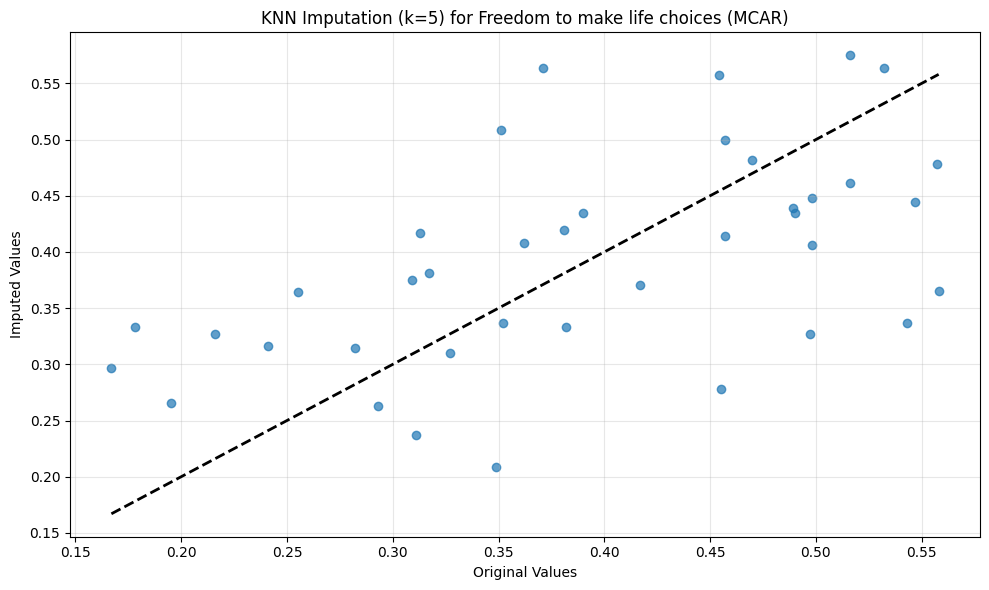

In [41]:
print("IMPUTATION METHOD 2: KNN IMPUTATION")

# Choose column and introduce missing values
target_column = 'Freedom to make life choices'
missing_mechanism = 'MCAR'
df_missing_2, missing_indices_2 = introduce_missing_values(
    original_df, target_column, mechanism=missing_mechanism, missing_rate=0.25
)

# Select features for KNN imputation
features = ['GDP per capita', 'Social support', 'Healthy life expectancy', 'Score', 'Generosity']
df_for_knn = df_missing_2[features + [target_column]].copy()

# Scale features for better KNN performance
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df_for_knn[features]),
    columns=features,
    index=df_for_knn.index
)
df_scaled[target_column] = df_for_knn[target_column]

# Find optimal k value
k_values = [3, 5, 7, 10, 15]
knn_results = {}

for k in k_values:
    imputer = KNNImputer(n_neighbors=k)
    imputed_array = imputer.fit_transform(df_scaled)
    df_imputed_knn = pd.DataFrame(imputed_array, columns=df_scaled.columns, index=df_scaled.index)
    
    original_values = original_df.loc[missing_indices_2, target_column]
    imputed_values = df_imputed_knn.loc[missing_indices_2, target_column]
    
    metrics = evaluate_imputation(original_values, imputed_values)
    knn_results[k] = metrics
    print(f"KNN with k={k}: MAE={metrics['MAE']:.4f}, RMSE={metrics['RMSE']:.4f}, R²={metrics['R²']:.4f}")

# Use best k for final imputation
best_k = min(knn_results.keys(), key=lambda k: knn_results[k]['MAE'])
print(f"\nBest k value: {best_k}")

imputer = KNNImputer(n_neighbors=best_k)
imputed_array = imputer.fit_transform(df_scaled)
df_imputed_2 = df_missing_2.copy()
# Extract the target column from imputed array (it's the last column)
target_idx = list(df_scaled.columns).index(target_column)
df_imputed_2.loc[:, target_column] = imputed_array[:, target_idx]

# Evaluate KNN imputation
original_values = original_df.loc[missing_indices_2, target_column]
imputed_values = df_imputed_2.loc[missing_indices_2, target_column]
knn_metrics = evaluate_imputation(original_values, imputed_values)

print("\nKNN Imputation Results (best k):")
for metric, value in knn_metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot comparison
plot_comparison(
    original_values, 
    imputed_values, 
    f'KNN Imputation (k={best_k}) for {target_column} ({missing_mechanism})'
)

IMPUTATION METHOD 3: MICE IMPUTATION
Created 46 missing values (30%) in column 'Perceptions of corruption' using MNAR mechanism

MICE Imputation Results:
MAE: 0.0902
RMSE: 0.1221
R²: -0.0911


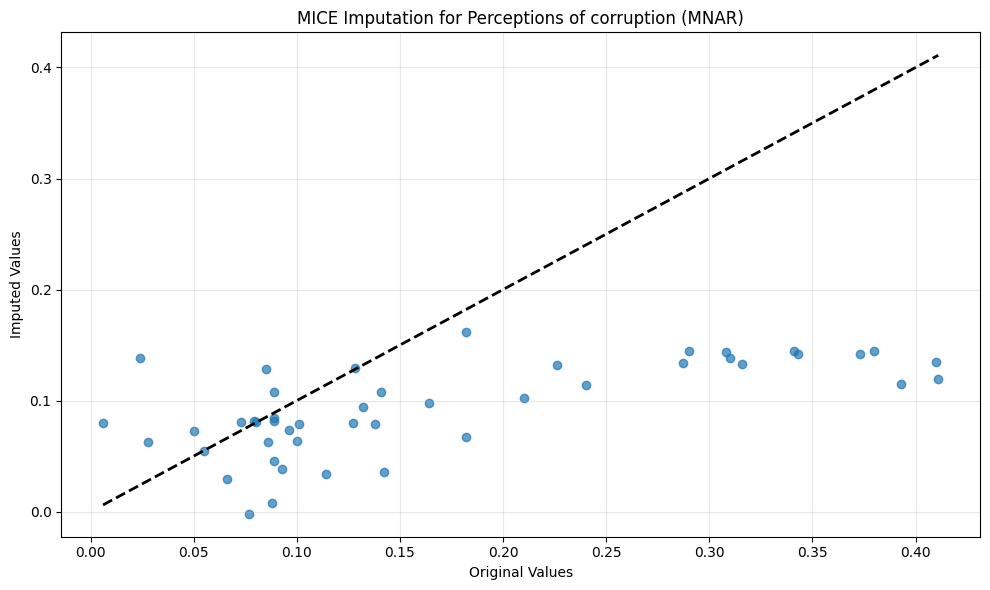

In [42]:
print("IMPUTATION METHOD 3: MICE IMPUTATION")

# Choose column and introduce missing values
target_column = 'Perceptions of corruption'
missing_mechanism = 'MNAR'
df_missing_3, missing_indices_3 = introduce_missing_values(
    original_df, target_column, mechanism=missing_mechanism, missing_rate=0.3
)

# Select features for MICE imputation
features = ['GDP per capita', 'Social support', 'Healthy life expectancy', 
            'Freedom to make life choices', 'Generosity', 'Score', target_column]
df_for_mice = df_missing_3[features].copy()

# Apply MICE imputation
mice_imputer = IterativeImputer(
    estimator=LinearRegression(),
    max_iter=10,
    random_state=42,
    verbose=0
)

imputed_array = mice_imputer.fit_transform(df_for_mice)
df_imputed_mice = pd.DataFrame(imputed_array, columns=features, index=df_for_mice.index)

# Create final imputed dataframe
df_imputed_3 = df_missing_3.copy()
df_imputed_3[target_column] = df_imputed_mice[target_column]

# Evaluate MICE imputation
original_values = original_df.loc[missing_indices_3, target_column]
imputed_values = df_imputed_3.loc[missing_indices_3, target_column]
mice_metrics = evaluate_imputation(original_values, imputed_values)

print("\nMICE Imputation Results:")
for metric, value in mice_metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot comparison
plot_comparison(
    original_values, 
    imputed_values, 
    f'MICE Imputation for {target_column} ({missing_mechanism})'
)




Comparison of All Imputation Methods:
       Method            Target Variable Missing Mechanism       MAE  \
0  Regression    Healthy life expectancy               MAR  0.147037   
1         KNN                 Generosity              MCAR  0.084241   
2        MICE  Perceptions of corruption              MNAR  0.090229   

       RMSE        R²  
0  0.180274  0.800065  
1  0.099876  0.211446  
2  0.122076 -0.091055  


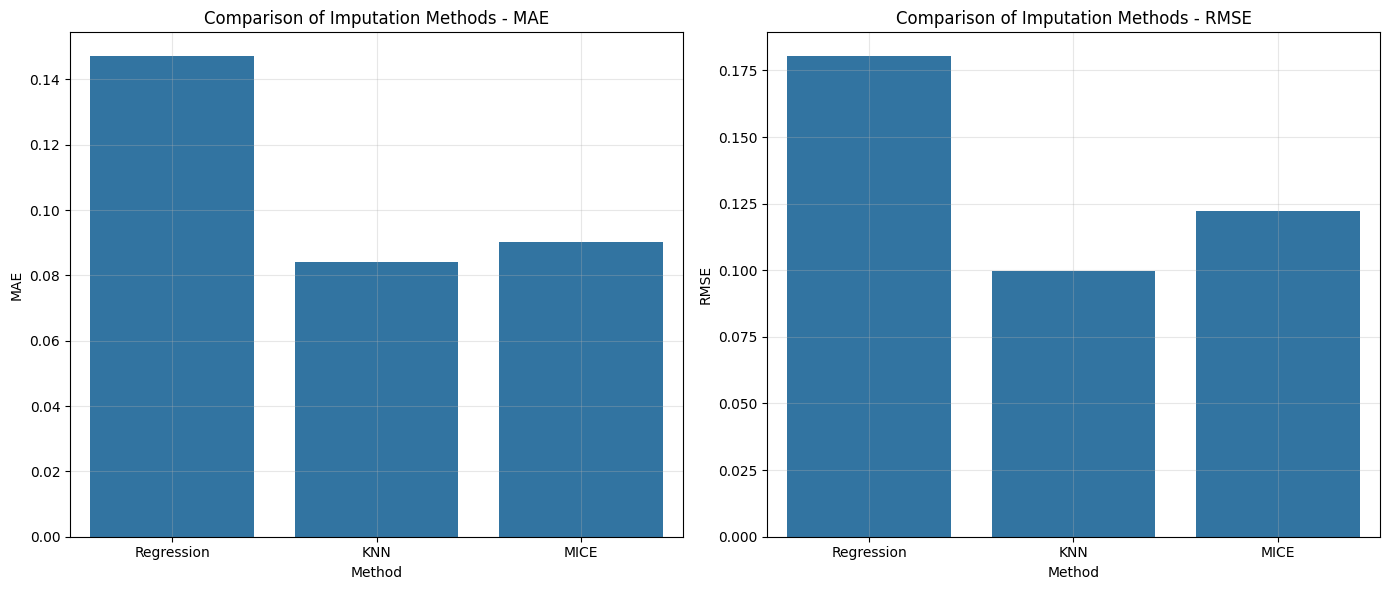

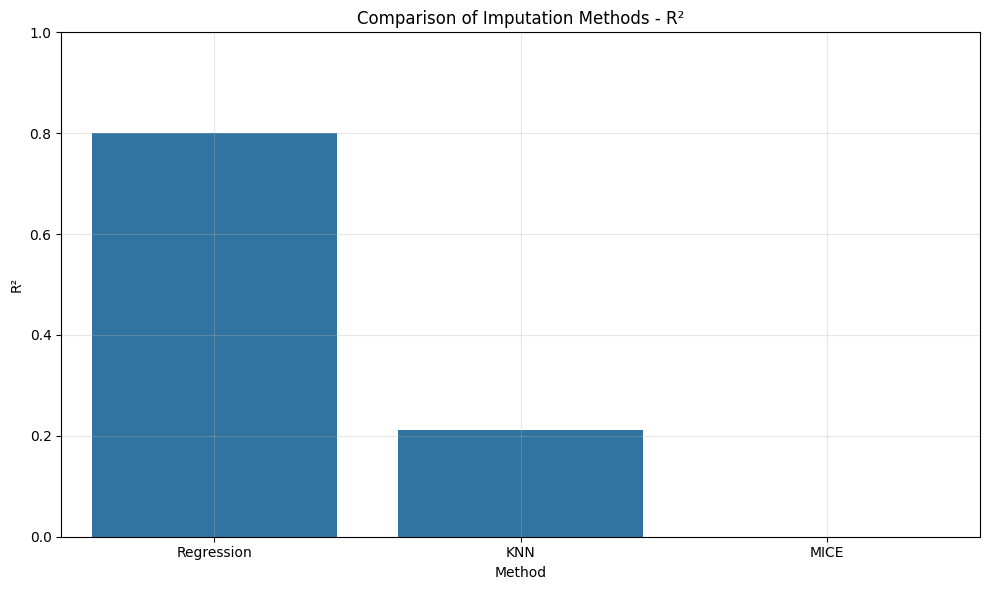

In [43]:
# Compare all imputation methods
methods = ['Regression', 'KNN', 'MICE']
metrics = ['MAE', 'RMSE', 'R²']
results = [regression_metrics, knn_metrics, mice_metrics]

# Create a summary dataframe
comparison_df = pd.DataFrame([
    {
        'Method': method,
        'Target Variable': target,
        'Missing Mechanism': mech,
        'MAE': res['MAE'],
        'RMSE': res['RMSE'],
        'R²': res['R²']
    }
    for method, target, mech, res in zip(
        methods, 
        ['Healthy life expectancy', 'Generosity', 'Perceptions of corruption'],
        ['MAR', 'MCAR', 'MNAR'],
        results
    )
])

print("\nComparison of All Imputation Methods:")
print(comparison_df)

# Visualize the comparison
plt.figure(figsize=(14, 6))
for i, metric in enumerate(['MAE', 'RMSE']):
    plt.subplot(1, 2, i+1)
    sns.barplot(data=comparison_df, x='Method', y=metric)
    plt.title(f'Comparison of Imputation Methods - {metric}')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualize R² comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=comparison_df, x='Method', y='R²')
plt.title('Comparison of Imputation Methods - R²')
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## References

### Data Analysis and Visualization Resources

#### 1. Seaborn Documentation

**Link:** [Seaborn Documentation](https://seaborn.pydata.org/)  
**How It Helped:**  
The Seaborn documentation was instrumental in helping us implement various visualizations like countplots, histograms, and scatterplots. 


---

### 2. Pandas Documentation

**Link:** [Pandas Documentation](https://pandas.pydata.org/docs/)  
**How It Helped:**  
Pandas' powerful data manipulation functions were essential in cleaning and transforming the dataset. 


---

### 3. OpenAI (ChatGPT), Claude, DeepSeek (R1)

**How It Helped:**  
OpenAI’s ChatGPT, ClaudeAI, and DeepSeek R1 helped by suggesting additional analysis techniques when we were brainstorming how to error-check the datasets. Addtionally, if we dealt with any code error, we used the AI to help us debug.


---

### 4. Stack Overflow

**Link:** [Stack Overflow](https://stackoverflow.com/)  
**How It Helped:**  
Stack Overflow was a key resource to better understand how we can make the required analysis for each error-check. 

---

### 5. Towards Data Science (Medium)

**Link:** [Towards Data Science](https://towardsdatascience.com/)  
**How It Helped:**  
The article on data exploration techniques from Towards Data Science helped us approach with unknown areas when dealing with error-checking. 

